In [1]:
# set plots inline for ipython
%matplotlib inline

# general python imports
from time import time

# Standard scientific Python imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix

# import datasets, preprocessing, piplining
from sklearn import datasets, metrics
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.image import grid_to_graph
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.cross_validation import train_test_split

# clustering
from sklearn.cluster import KMeans
from sklearn.mixture import GMM

# dimensionality reduction
from sklearn.decomposition import PCA, FastICA
from sklearn.random_projection import GaussianRandomProjection 
from sklearn.cluster import FeatureAgglomeration

# import the neural network stuff
from sknn.mlp import Classifier, Layer

In [2]:
# globals
n_row, n_col = 2, 5
n_components = n_row * n_col

# set random seed
rand_state = np.random.RandomState(32)

In [3]:
# function to plot different decompositions of the data
def plot_gallery(title, images, n_col=n_col, n_row=n_row, image_shape = (64, 64)):
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=plt.cm.gray,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)

In [4]:
def do_clustering(dataset, clustering_alg_dict, image_shape=(64,64)):
    for title, clustering in clustering_alg_dict.iteritems():
        t0 = time()
        clustering.fit(dataset)
        train_time = (time() - t0)
        
        if isinstance(clustering, Pipeline):
            clustering = clustering.steps[-1][1]

        if hasattr(clustering, 'means_'):
            components = clustering.means_
        elif hasattr(clustering, 'cluster_centers_'):
            components = clustering.cluster_centers_
            
        print type(clustering)

        plot_gallery('%s - Train time %.1fs' % (title, train_time),
                     components[:n_components], image_shape=image_shape)

In [5]:
def do_decompositions(dataset, decomposition_dict, image_shape=(64,64)):
    for title, decomposition in decompositions.iteritems():
        if not title == 'Feature Agglomeration':
            t0 = time()
            decomposition.fit(dataset)
            train_time = (time() - t0)

            plot_gallery('%s - Train time %.1fs' % (title, train_time),
                         decomposition.components_[:n_components], image_shape=image_shape)

In [6]:
# Load datasets
digits = datasets.load_digits()
faces = datasets.fetch_olivetti_faces(shuffle = True)

# normalize digits
digits_X = StandardScaler().fit_transform(digits.data)

# normalize olvetti faces
faces_X = StandardScaler().fit_transform(faces.data)

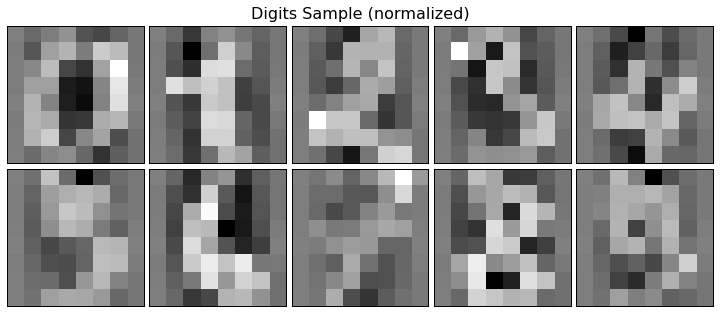

In [7]:
# show example digits
plot_gallery("Digits Sample (normalized)", digits_X[:n_components], image_shape=(8,8))

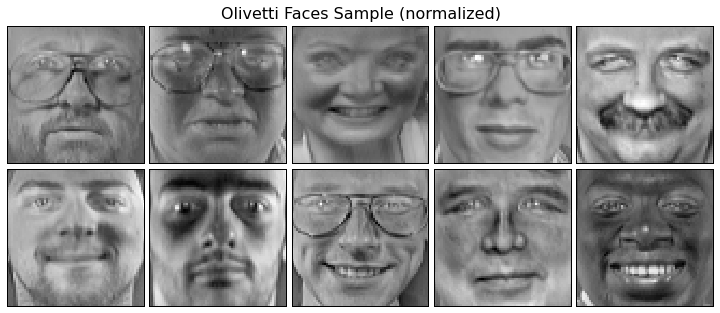

In [8]:
# show some example faces
plot_gallery("Olivetti Faces Sample (normalized)", faces_X[:n_components])

In [9]:
# digit clustering
clustering_algs = {
    'K-Means': KMeans(n_clusters=n_components),
    'Expectation Maximization': GMM(n_components=n_components)
}

In [10]:
# dimensionality reduction algorithms
decompositions = {
    'Principal Components Analysis': PCA(n_components=n_components, whiten=True),
    'Independent Components Analysis': FastICA(n_components=n_components, whiten=True),
    'Gaussian Random Projections': GaussianRandomProjection(n_components=n_components),
    'Feature Agglomeration': FeatureAgglomeration(n_clusters=32)
}

<class 'sklearn.cluster.k_means_.KMeans'>
<class 'sklearn.mixture.gmm.GMM'>


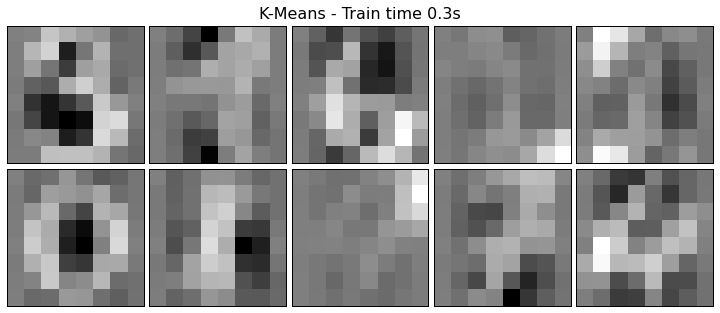

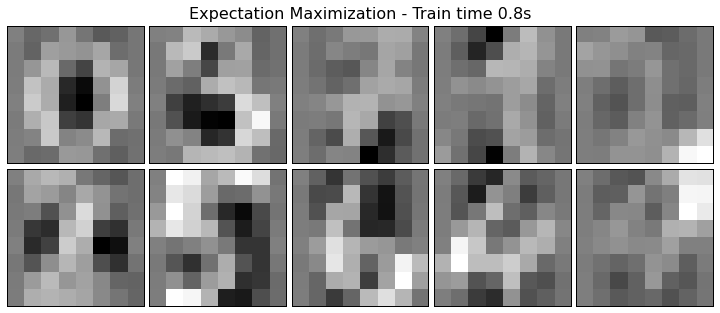

In [11]:
do_clustering(digits_X, clustering_algs, image_shape=(8,8))

<class 'sklearn.cluster.k_means_.KMeans'>
<class 'sklearn.mixture.gmm.GMM'>


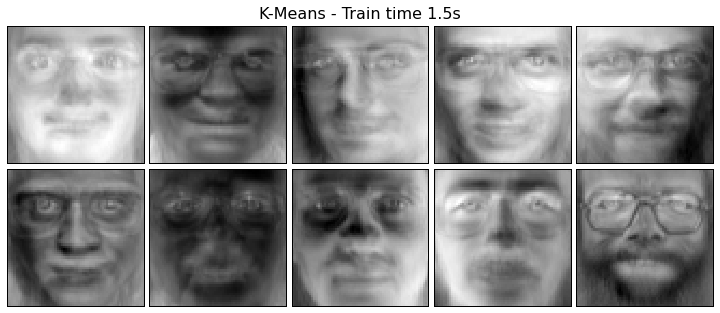

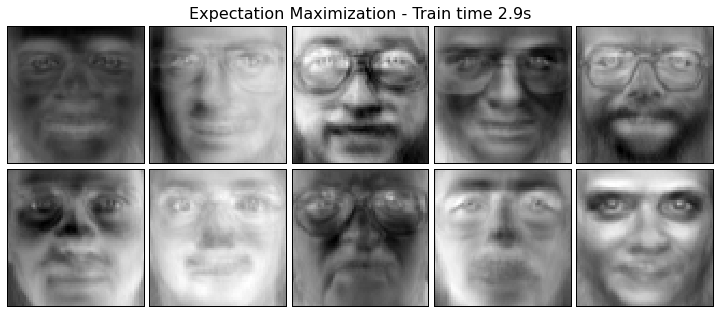

In [12]:
do_clustering(faces_X, clustering_algs)

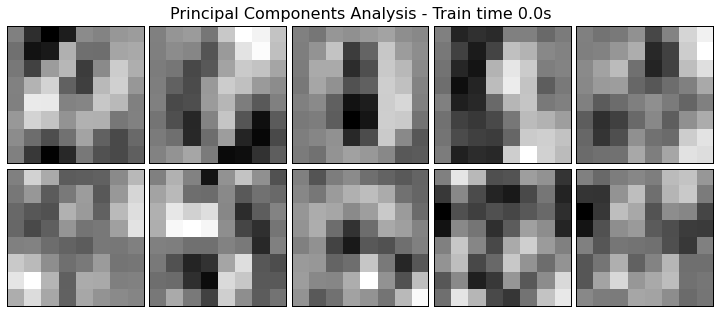

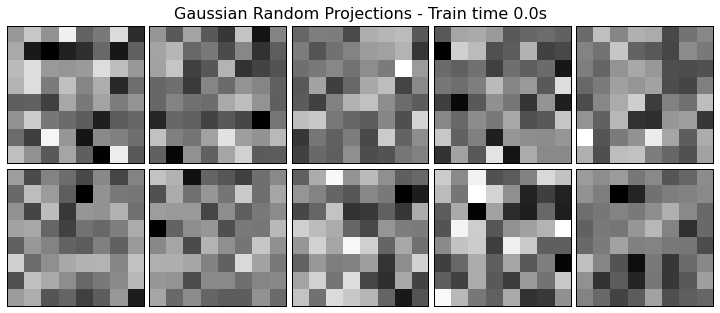

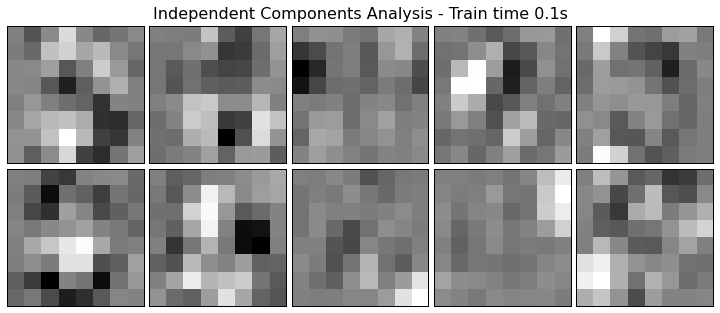

In [13]:
do_decompositions(digits_X, decompositions, image_shape=(8,8))

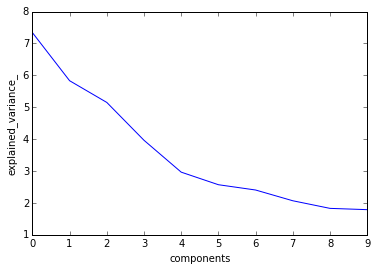

In [14]:
plt.plot(decompositions['Principal Components Analysis'].explained_variance_)
plt.xlabel('components')
plt.ylabel('explained_variance_')

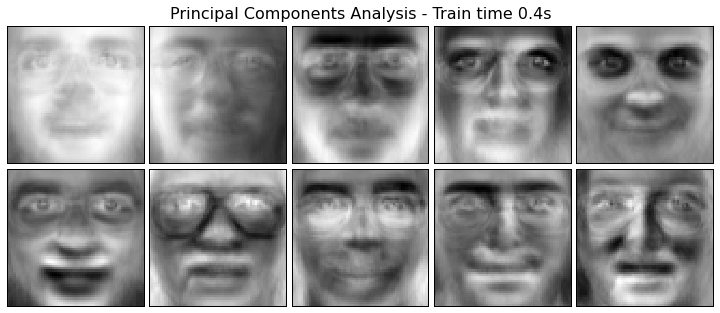

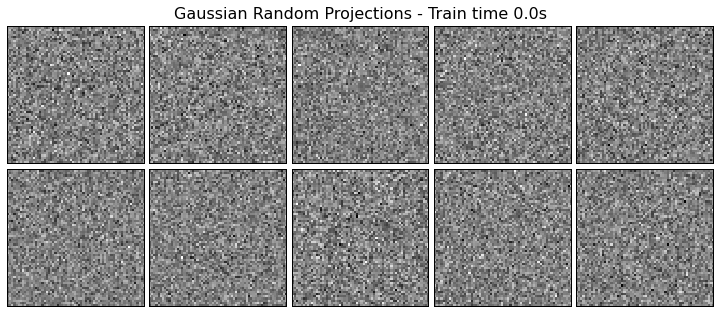

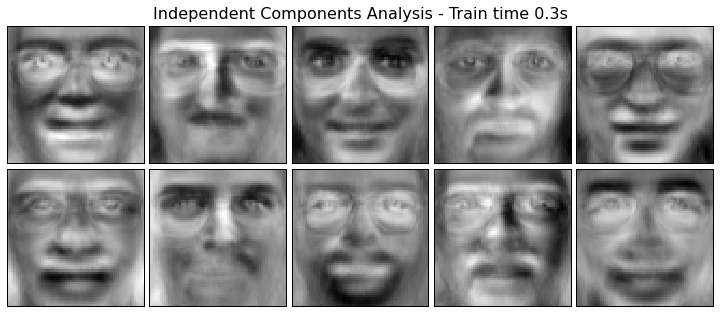

In [28]:
do_decompositions(faces_X, decompositions)

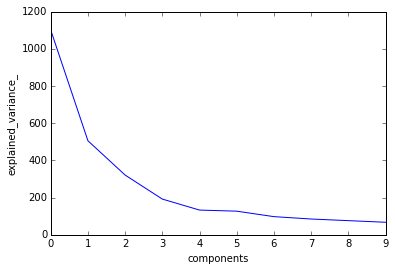

In [16]:
plt.plot(decompositions['Principal Components Analysis'].explained_variance_)
plt.xlabel('components')
plt.ylabel('explained_variance_')

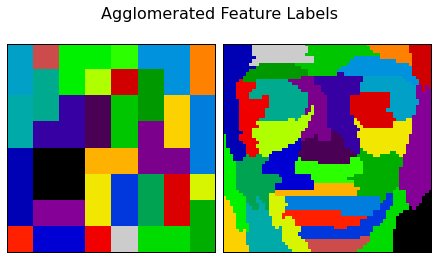

In [17]:
# do feature agglomerations
agglo = FeatureAgglomeration(n_clusters=32, connectivity=grid_to_graph(*digits.images[0].shape))
agglo.fit(digits_X)

plt.suptitle('Agglomerated Feature Labels', size=16)

plt.subplot(1,2,1)
plt.imshow(np.reshape(agglo.labels_, digits.images[0].shape),
           interpolation='nearest', cmap=plt.cm.spectral)
plt.xticks(())
plt.yticks(())

# do feature agglomerations
agglo = FeatureAgglomeration(n_clusters=32, connectivity=grid_to_graph(*faces.images[0].shape))
agglo.fit(faces_X)

plt.subplot(1,2,2)
plt.imshow(np.reshape(agglo.labels_, faces.images[0].shape),
           interpolation='nearest', cmap=plt.cm.spectral)
plt.xticks(())
plt.yticks(())

plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)

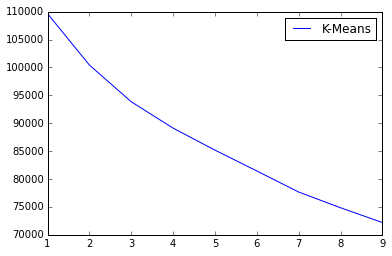

In [18]:
inertia = pd.DataFrame(columns=['K-Means'])

for n_clusters in range(1,10):
    clustering_algs['K-Means'].n_clusters = n_clusters
    clustering_algs['K-Means'].fit(digits_X)

    inertia.set_value(n_clusters, 'K-Means', clustering_algs['K-Means'].inertia_)
        
inertia.plot()

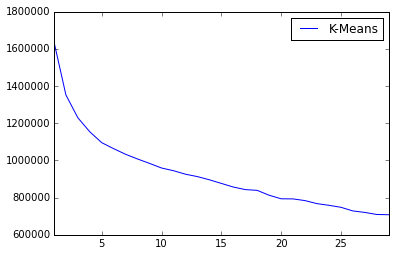

In [19]:
inertia = pd.DataFrame(columns=['K-Means'])

for n_clusters in range(1,30):
    clustering_algs['K-Means'].n_clusters = n_clusters
    clustering_algs['K-Means'].fit(faces_X)

    inertia.set_value(n_clusters, 'K-Means', clustering_algs['K-Means'].inertia_)
        
inertia.plot()

In [32]:
# connectivity for the two datasets (used by feature agglomeration)
digit_connectivity = grid_to_graph(*digits.images[0].shape)
face_connectivity = grid_to_graph(*faces.images[0].shape)

# lets speed things along via pipelines!
digit_clustering_pipes = {
    'K-means':make_pipeline(KMeans(n_clusters=n_components)),
    'K-Means(PCA)': make_pipeline(PCA(n_components=n_components, whiten=True), KMeans(n_clusters=n_components)),
    'K-Means(ICA)': make_pipeline(FastICA(n_components=n_components, whiten=True), KMeans(n_clusters=n_components)),
    'K-Means(Random Projections)': make_pipeline(GaussianRandomProjection(n_components=n_components), KMeans(n_clusters=n_components)),
    'K-Means(Feature Agglo)': make_pipeline(FeatureAgglomeration(n_clusters=32, connectivity=digit_connectivity), KMeans(n_clusters=n_components))
}

face_clustering_pipes = {
    'K-means':make_pipeline(KMeans(n_clusters=n_components)),
    'K-Means(PCA)': make_pipeline(PCA(n_components=n_components, whiten=True), KMeans(n_clusters=n_components)),
    'K-Means(ICA)': make_pipeline(FastICA(n_components=n_components, whiten=True), KMeans(n_clusters=n_components)),
    'K-Means(Random Projections)': make_pipeline(GaussianRandomProjection(n_components=n_components), KMeans(n_clusters=n_components)),
    'K-Means(Feature Agglo)': make_pipeline(FeatureAgglomeration(n_clusters=32, connectivity=face_connectivity), KMeans(n_clusters=n_components))
}

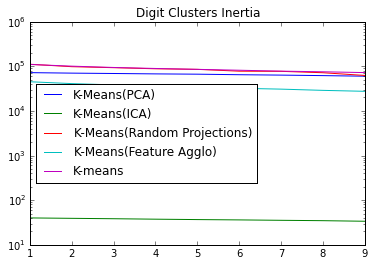

In [43]:
inertia_piped = pd.DataFrame(columns=['K-Means(PCA)','K-Means(ICA)','K-Means(Random Projections)','K-Means(Feature Agglo)'])

for n_clusters in range(1,10):
    for label, pipe in digit_clustering_pipes.iteritems():
        pipe.set_params(kmeans__n_clusters = n_clusters).fit(digits_X)
        
        inertia_piped.set_value(n_clusters, label, pipe.steps[-1][-1].inertia_)
        
inertia_piped.plot(logy=True, title='Digit Clusters Inertia')
        

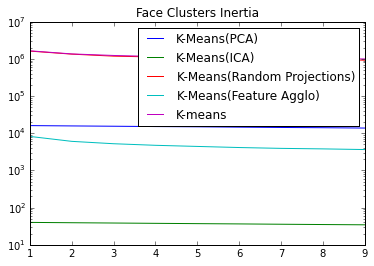

In [42]:
for n_clusters in range(1,10):
    for label, pipe in face_clustering_pipes.iteritems():
        pipe.set_params(kmeans__n_clusters = n_clusters).fit(faces_X)
        
        inertia_piped.set_value(n_clusters, label, pipe.steps[-1][1].inertia_)
        
inertia_piped.plot(logy=True, title='Face Clusters Inertia')

In [23]:
# split the data for supervised learning portion
X_train, X_test, y_train, y_test = train_test_split(faces_X, faces.target, test_size=0.3, random_state=rand_state)

In [24]:
n_components = 40

preprocessors = {
    'No preprocess' : None,
    'Principal Components Analysis': PCA(n_components=n_components, whiten=True),
    'Independent Components Analysis': FastICA(n_components=n_components, whiten=True),
    'Gaussian Random Projections': GaussianRandomProjection(n_components=n_components),
    'Feature Agglomeration': FeatureAgglomeration(n_clusters=n_components, connectivity=grid_to_graph(*faces.images[0].shape)),
    'K-Means': KMeans(n_clusters=n_components)
}

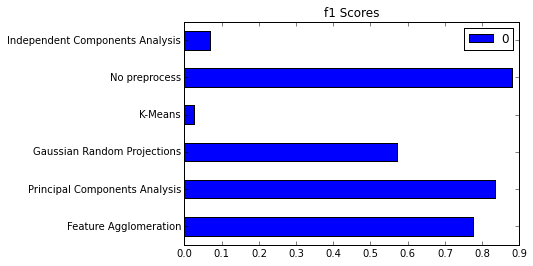

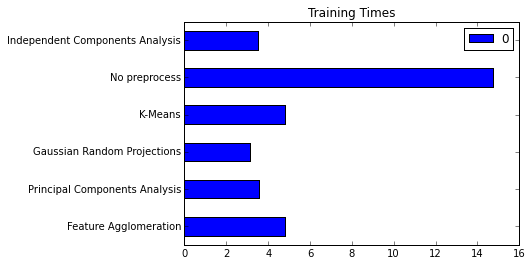

In [41]:
results = {}
wallclock = {}

for title, process in preprocessors.iteritems():
    if process == None:
        nn_ = Classifier(layers=[
                Layer("Maxout", units=100, pieces=2),
                Layer("Softmax")],learning_rate=0.001,n_iter=25)
    else:
        nn_ = make_pipeline(process, Classifier(layers=[
                Layer("Maxout", units=100, pieces=2),
                Layer("Softmax")],learning_rate=0.001,n_iter=25))

    t0 = time()
    nn_.fit(X_train, y_train)
    wallclock[title] = (time() - t0)
    
    y_pred = nn_.predict(X_test)

    results[title] = metrics.f1_score(y_test, y_pred, average='weighted')
    
pd.DataFrame.from_dict(results, orient='index').plot(kind='barh', title='f1 Scores')
pd.DataFrame.from_dict(wallclock, orient='index').plot(kind='barh', title='Training Times')

|Assignment  Step |		Index |	Experiment# |	Dataset A |	Dataset B|
|---|---|---|---|---|---|
|1		|	1 |	1	|	kmeans(A)	| kmeans(B) |
|1		|	2 | 3	|	em(A)	|	em(B)  |
|2		|	3 |	5	|	PCA(A)	|	PCA(B) |
|2		|	4 |	7	|	ICA(A)	|	ICA(B) |
|2		|	5 |	9	|	RP(A)	|	RP(B) |
|2		|	6 |	11	|	CYO(A)	|	CYO(B) |
|3		|	7 |	13	|	kmeans(PCA(A)) |	kmeans(PCA(B)) |
|3		|	8 |	15	|	kmeans(ICA(A)) |	kmeans(ICA(B)) |
|3		|	9 |	17	|	kmeans(RP(A)) |	kmeans(RP(B)) |
|3		|	10 |	19	|	kmeans(CYO(A)) |	kmeans(CYO(B)) |
|3		|	11 |	21	|	em(PCA(A)) |	em(PCA(B)) |
|3		|	12 |	23	|	em(ICA(A)) |	em(ICA(B)) |
|3		|	13 |	25	|	em(RP(A)) |	em(RP(B)) |
|3		|	14 |	27	|	em(CYO(A)) |	em(CYO(B)) |
|4		|	15	 | 29	|	Nnet(PCA(A)) |     |
|4		|	16 |	30	|	Nnet(ICA(A))  |   |
|4		|	17 |	31	|	Nnet(RP(A)) | |
|4		|	18 |	32	|	Nnet(CYO(A)) |  |
|5		|	19 |	33	|	Nnet(kmeans(A)) | |   
|5		|	20 |	34	|	Nnet(em(A))  | |